# necessary libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim 
import cv2 as cv
import numpy as np

# plt.style.use('dark_background')
plt.style.use('default')



# Dataset Class

In [41]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/ishaq/Downloads/data/concrete_crack_images_for_classification"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples = len(positive_files) + len(negative_files)

        #idx
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

## The mean and standard deviation (std) values are used for data normalization during preprocessing of images in machine learning tasks, especially in deep learning models like CNNs. Normalizing the data helps the model to converge faster and improve training stability.

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

## Dataset objects for validation and training

In [42]:
train_dataset = Dataset(transform=transform, train=True)
validation_dataset = Dataset(transform=transform, train=False)

In [43]:
train_dataset[0][0].shape

torch.Size([3, 227, 227])

# Normal CNN Architecture

In [6]:
# class CNN(nn.Module):
    
#     # Contructor
#     def __init__(self, out_1=16,number_of_classes=2):
#         super(CNN, self).__init__()
#         self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
#         self.maxpool1=nn.MaxPool2d(kernel_size=2)

#         self.fc1 = nn.Linear(out_1 * 113 * 113, number_of_classes)
    
#     # Prediction
#     def forward(self, x):
#         x = self.cnn1(x)            # CNN Layer one
#         x = torch.relu(x)
#         x = self.maxpool1(x)
        
#         x = x.view(x.size(0), -1)  # NN Layer one
#         x = self.fc1(x)
#         return x

In [7]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=96, out_2=256, number_of_classes=2):
        super(CNN, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=11, stride=4)
        self.maxpool1=nn.MaxPool2d(kernel_size=3, stride=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=3, stride=2)
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 13 * 13, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, number_of_classes)
        )
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# the actual AlexNet Network (i havn't exactly used this one since it would be too overwhelming)

In [8]:
# class AlexNet_original(nn.Module):
#     def __init__(self, num_classes):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             nn.Conv2d(96, 256, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             nn.Conv2d(256, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(384, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
            
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(4096, num_classes)
#         )
        
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x



# instead i have used this one which has been tweaked a bit by me (i have removed a couple CNN layers)

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



## in case you  want to use the pretrained version of the models

In [10]:
# Alex_model = torch.load("Alex_model.pth")
# CNN_model = torch.load("CNN_model.pth")

# or if you want to train your own model

In [11]:
Alex_model = AlexNet(2) # two is the number of classes
CNN_model = CNN()

In [12]:
# Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=300)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=200)

### custom CNN Architecture training

In [13]:
# Optimizer and Criterion
learing_rate=0.1
momentum=0.1
optimizer=torch.optim.SGD(CNN_model.parameters(), lr=learing_rate, momentum=momentum)
criterion=nn.CrossEntropyLoss()

In [20]:
epochs=15
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)
i=-1
# learning_rates=[0.1,0.01,0.001]

for epoch in range(epochs):
    for x,y in train_loader:
        optimizer.zero_grad()
        z=CNN_model(x)
        loss=criterion(z,y)
        loss.backward()
        optimizer.step()
        i+=1
        if i%30==0:
            print(f"loader{i}")
        
    correct=0
    for x_test,y_test in validation_loader:
        z=CNN_model(x_test)
        _,yhat=torch.max(z.data,1)
        correct += (yhat==y_test).sum().item()
        
    accuracy_list.append(correct/N_test)
    loss_list.append(loss.data)
    print(f"epoch: {epoch}\t accuracy: {correct/N_test}\t loss: {loss.data}")

loader0
loader30
loader60
loader90
epoch: 0	 accuracy: 0.9904	 loss: 0.054280076175928116
loader120
loader150
loader180
epoch: 1	 accuracy: 0.9918	 loss: 0.045694831758737564
loader210
loader240
loader270
epoch: 2	 accuracy: 0.991	 loss: 0.03258041664958
loader300
loader330
loader360
loader390
epoch: 3	 accuracy: 0.993	 loss: 0.027096452191472054
loader420
loader450
loader480
epoch: 4	 accuracy: 0.9936	 loss: 0.024248292669653893
loader510
loader540
loader570
epoch: 5	 accuracy: 0.9942	 loss: 0.015724794939160347
loader600
loader630
loader660
loader690
epoch: 6	 accuracy: 0.9952	 loss: 0.010072056204080582
loader720
loader750
loader780
epoch: 7	 accuracy: 0.9957	 loss: 0.013137830421328545
loader810
loader840
loader870
epoch: 8	 accuracy: 0.9959	 loss: 0.0057792216539382935
loader900
loader930
loader960
loader990
epoch: 9	 accuracy: 0.9941	 loss: 0.004133207257837057
loader1020
loader1050
loader1080
epoch: 10	 accuracy: 0.9958	 loss: 0.002590721705928445
loader1110
loader1140
loader117

In [ ]:
# it saves your model
torch.save(CNN_model, "CNN_model.pth")

### AlexNet Architecture training

In [21]:
learing_rate=0.1
momentum=0.1
optimizer=torch.optim.SGD(Alex_model.parameters(), lr=learing_rate, momentum=momentum)
criterion=nn.CrossEntropyLoss()

In [22]:
epochs=5
loss_list1 = []
accuracy_list1 = []
N_test1 = len(validation_dataset)
i=-1

for epoch in range(epochs):
    for x,y in train_loader:
        optimizer.zero_grad()
        z=Alex_model(x)
        loss=criterion(z,y)
        loss.backward()
        optimizer.step()
        i+=1
        if i%30==0:
            print(f"loader{i}")
        
    correct=0
    for x_test,y_test in validation_loader:
        z=Alex_model(x_test)
        _,yhat=torch.max(z.data,1)
        correct += (yhat==y_test).sum().item()
        
    accuracy_list1.append(correct/N_test1)
    loss_list1.append(loss.data)
    print(f"epoch: {epoch}")

In [23]:
# it saves the model
torch.save(Alex_model, "Alex_model.pth")

### the comparison of the accuracy and the loss data of the above two models

In [ ]:
print(f"accuracy_Normal_CNN: {accuracy_list}\tLoss_Normal_CNN: {loss_list}\naccuracy_AlexNet: {accuracy_list1}\tLoss_AlexNet: {loss_list1}")

In [25]:
import subprocess

video_file = "/home/ishaq/Downloads/beep_beep.mp3"
output_audio_file = "/tmp/extracted_audio4.wav"

# Extract audio from the video using ffmpeg
subprocess.call(["ffmpeg", "-i", video_file, "-vn", "-acodec", "pcm_s16le", output_audio_file])

# Play the extracted audio using aplay (Linux)
subprocess.call(["aplay", output_audio_file])

ffmpeg version 4.4.2-0ubuntu0.22.04.1+esm1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.3.0-1ubuntu1~22.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1+esm1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enabl

KeyboardInterrupt: 

# Kernals plotting

### AlexNet

In [14]:
Alex_model = torch.load("Alex_model.pth")

In [15]:
accuracy_list1=[]
N_test1=len(validation_dataset)

correct=0
for x_test,y_test in validation_loader:
    z=Alex_model(x_test)
    _,yhat=torch.max(z.data,1)
    correct += (yhat==y_test).sum().item()
    
accuracy_list1.append(correct/N_test1)
accuracy_list1

[0.9929]

In [16]:
Alex_model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[ 0.0309, -0.0119,  0.0029,  ..., -0.0327,  0.0379,  0.0139],
                        [-0.0567, -0.0267, -0.0163,  ..., -0.0428,  0.0161, -0.0150],
                        [-0.0417,  0.0018,  0.0205,  ..., -0.0287, -0.0011, -0.0180],
                        ...,
                        [-0.0357, -0.0621,  0.0274,  ...,  0.0340, -0.0263, -0.0507],
                        [-0.0411,  0.0037,  0.0169,  ...,  0.0083, -0.0339, -0.0129],
                        [-0.0460, -0.0204, -0.0425,  ...,  0.0233, -0.0554, -0.0416]],
              
                       [[-0.0010,  0.0025, -0.0643,  ..., -0.0667, -0.0105, -0.0652],
                        [ 0.0110,  0.0281,  0.0052,  ..., -0.0657,  0.0198, -0.0005],
                        [-0.0303, -0.0549,  0.0290,  ...,  0.0024,  0.0192, -0.0105],
                        ...,
                        [-0.0311, -0.0259, -0.0192,  ...,  0.0093, -0.0067, -0.0483],
                        [-0.039

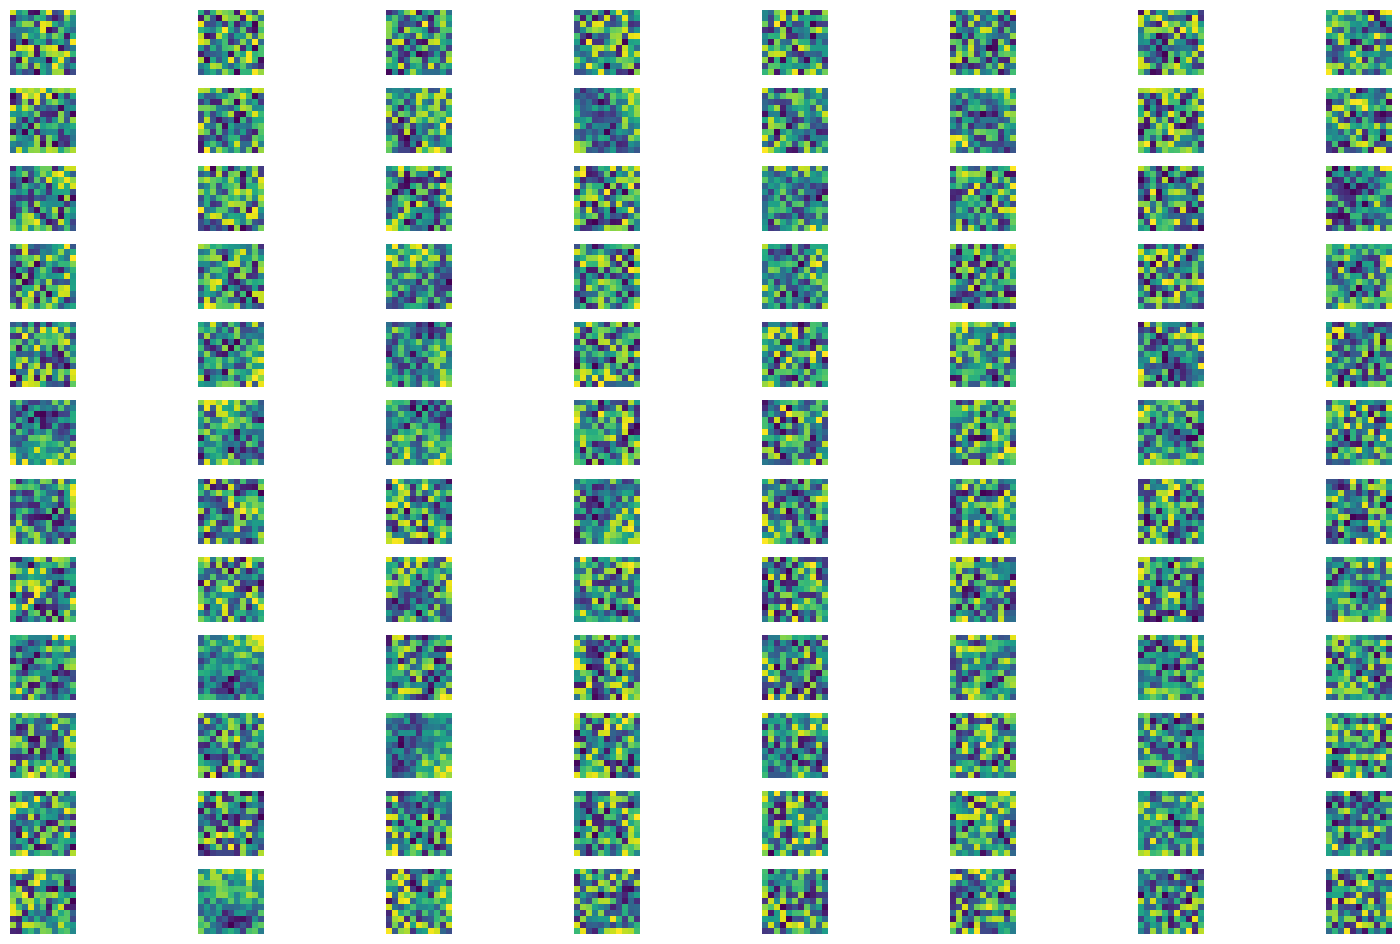

In [32]:
kernels = Alex_model.state_dict()['features.0.weight']  

num_rows = 12
num_cols = 8 

# Calculate the total number of subplots needed
num_kernels = kernels.shape[0]
total_subplots = num_rows * num_cols

plt.figure(figsize=(19, 12))

# Loop through the kernels and plot them
for i in range(total_subplots):
    if i < num_kernels:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(kernels[i, 0].cpu().numpy(), cmap='viridis')  
        plt.axis('off')
    else:
        # Blank subplot for any unused positions
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')

plt.show()


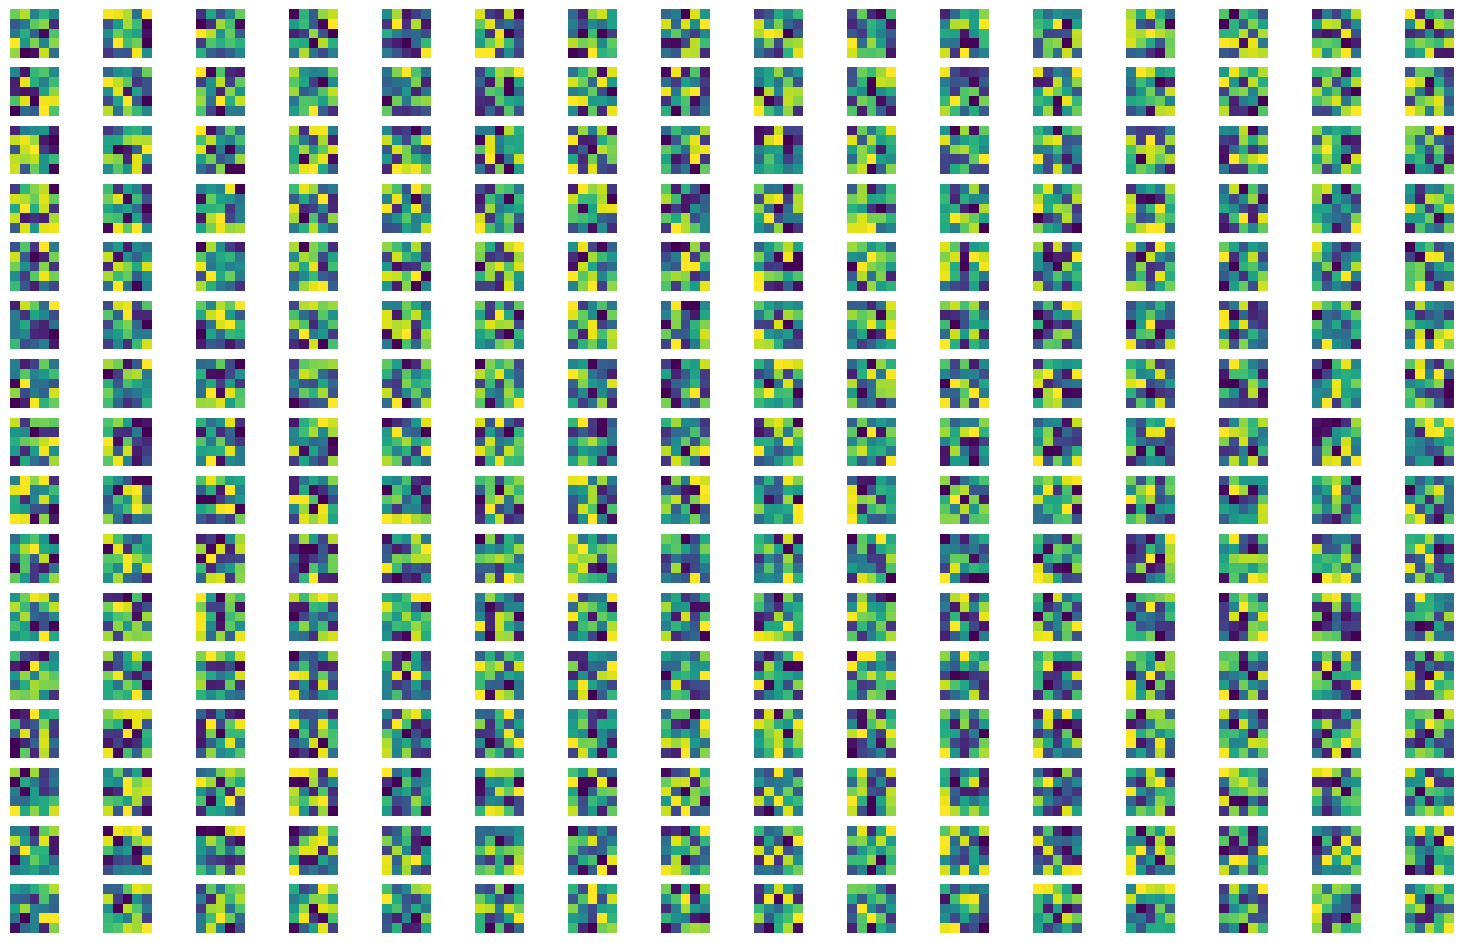

In [34]:
kernels = Alex_model.state_dict()['features.3.weight']

num_rows = 16  
num_cols = 16  

# Calculate the total number of subplots needed
num_kernels = kernels.shape[0]
total_subplots = num_rows * num_cols

plt.figure(figsize=(19, 12))

# Loop through the kernels and plot them
for i in range(total_subplots):
    if i < num_kernels:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(kernels[i, 0].cpu().numpy(), cmap='viridis')  
        plt.axis('off')
    else:
        # Blank subplot for any unused positions
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')

plt.show()


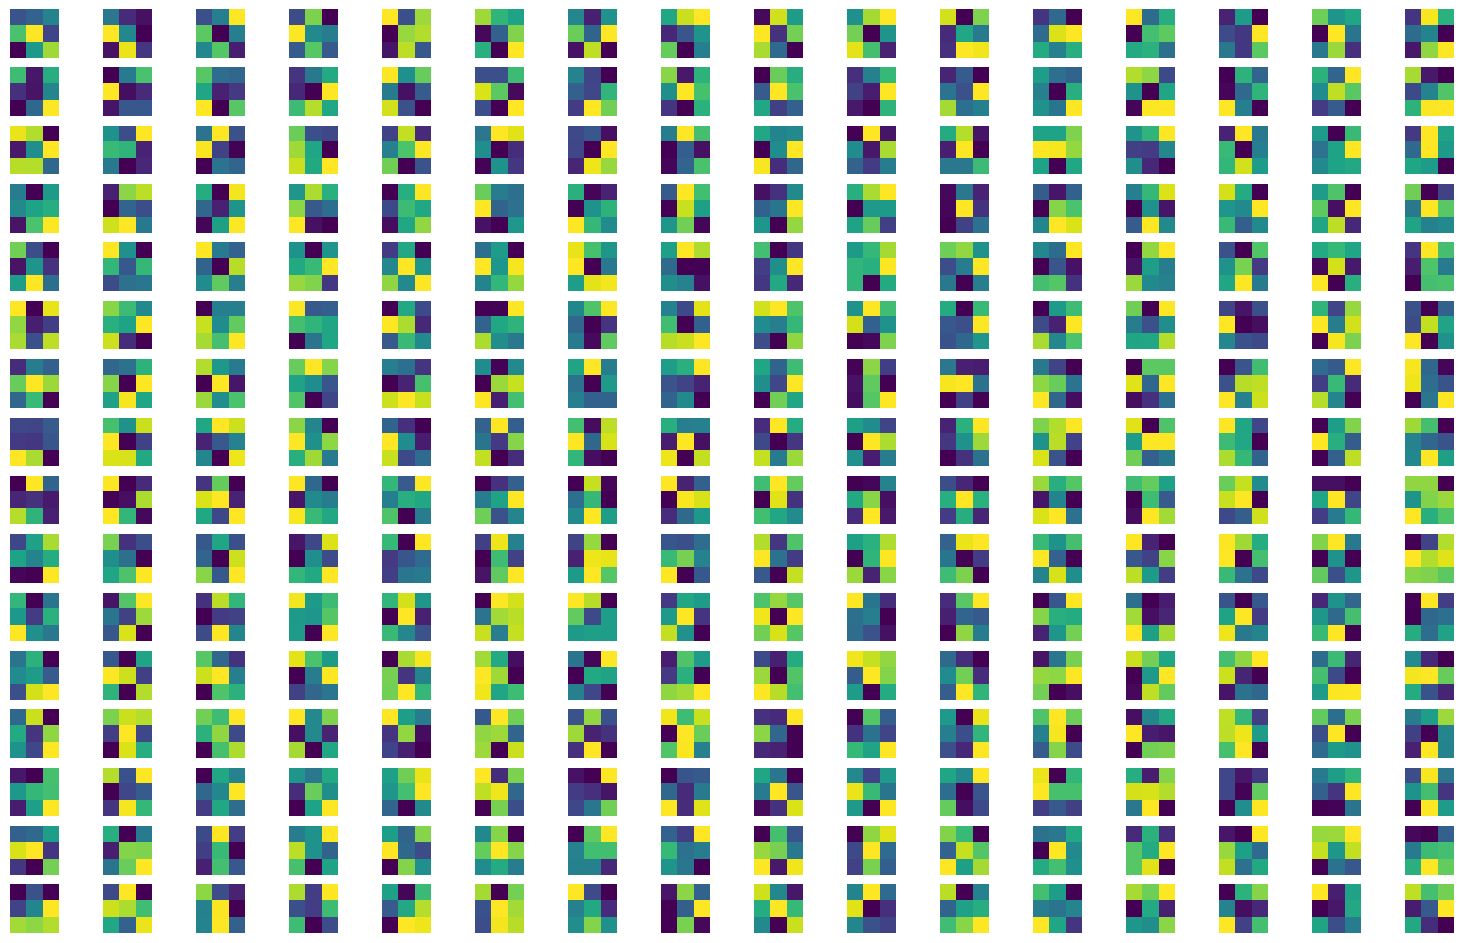

In [35]:
kernels = Alex_model.state_dict()['features.6.weight']

num_rows = 16 
num_cols = 16  

# Calculate the total number of subplots needed
num_kernels = kernels.shape[0]
total_subplots = num_rows * num_cols

plt.figure(figsize=(19, 12))

# Loop through the kernels and plot them
for i in range(total_subplots):
    if i < num_kernels:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(kernels[i, 0].cpu().numpy(), cmap='viridis')
        plt.axis('off')
    else:
        # Blank subplot for any unused positions
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')

plt.show()


### custom CNN Architecture

In [20]:
CNN_model = torch.load("CNN_model.pth")

In [21]:
accuracy_list=[]
N_test=len(validation_dataset)

correct=0
for x_test,y_test in validation_loader:
    z=Alex_model(x_test)
    _,yhat=torch.max(z.data,1)
    correct += (yhat==y_test).sum().item()
    
accuracy_list.append(correct/N_test)
accuracy_list

[0.9928]

In [22]:
CNN_model.state_dict()

OrderedDict([('cnn1.weight',
              tensor([[[[-0.0366, -0.0151,  0.0453,  ...,  0.0275, -0.0109,  0.0148],
                        [-0.0176, -0.0090, -0.0386,  ...,  0.0369,  0.0482, -0.0244],
                        [ 0.0504,  0.0108, -0.0097,  ..., -0.0075, -0.0268, -0.0388],
                        ...,
                        [ 0.0027,  0.0262, -0.0263,  ..., -0.0591, -0.0525, -0.0422],
                        [-0.0174, -0.0524,  0.0165,  ..., -0.0316,  0.0043, -0.0548],
                        [-0.0136, -0.0485, -0.0658,  ...,  0.0288, -0.0213, -0.0331]],
              
                       [[-0.0303,  0.0354,  0.0492,  ...,  0.0123,  0.0178, -0.0094],
                        [ 0.0362, -0.0372,  0.0419,  ..., -0.0257, -0.0109, -0.0069],
                        [-0.0179, -0.0215, -0.0329,  ...,  0.0531,  0.0175, -0.0411],
                        ...,
                        [-0.0305,  0.0403,  0.0189,  ..., -0.0145, -0.0671,  0.0029],
                        [ 0.0397, -0.

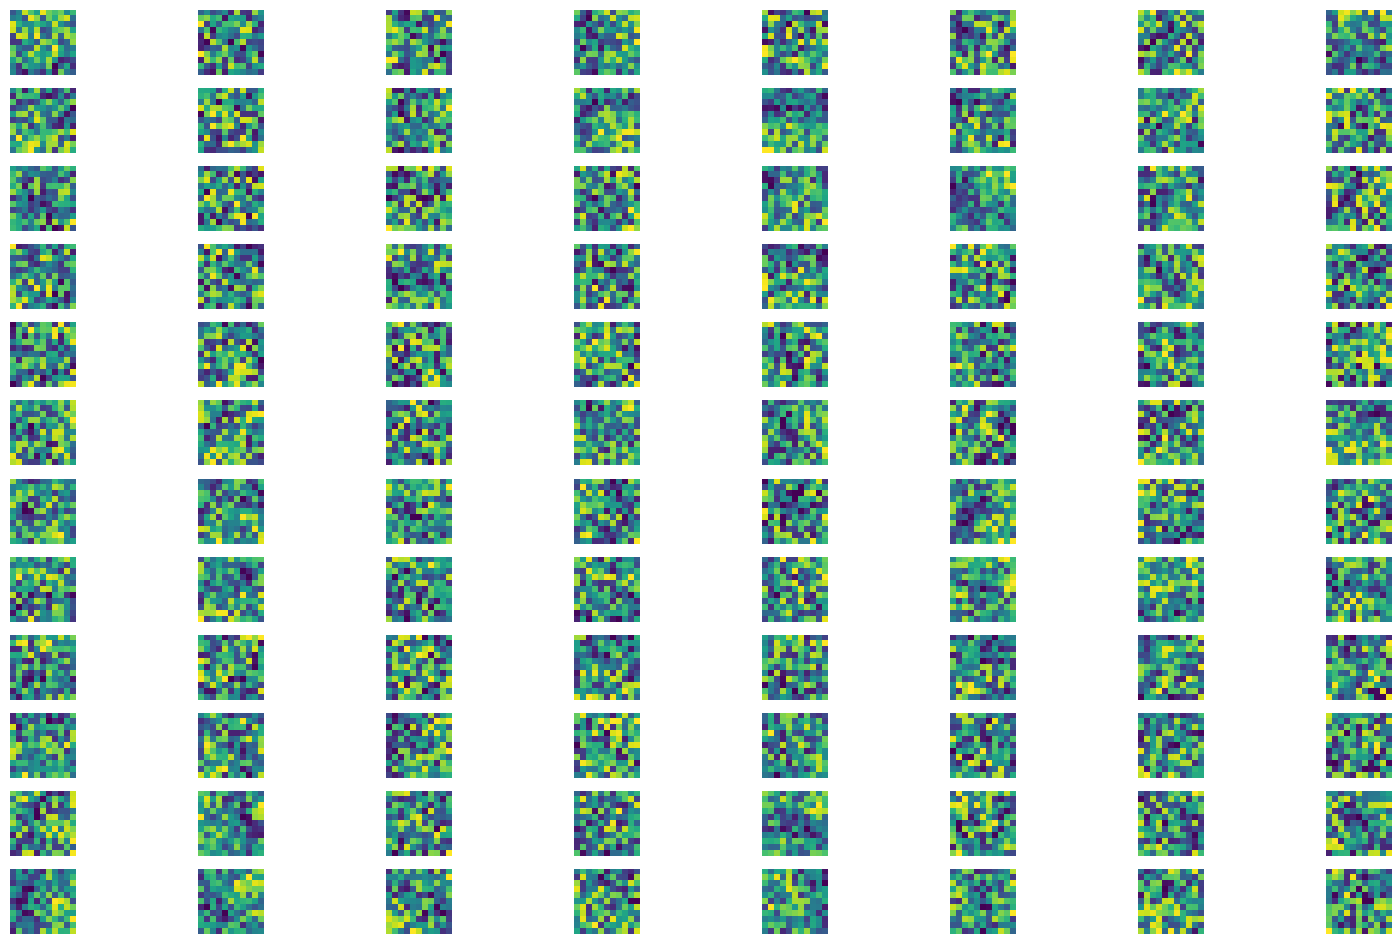

In [40]:
kernels = CNN_model.state_dict()['cnn1.weight']  

num_rows = 12 
num_cols = 8  

# Calculate the total number of subplots needed
num_kernels = kernels.shape[0]
total_subplots = num_rows * num_cols

plt.figure(figsize=(19, 12))

# Loop through the kernels and plot them
for i in range(total_subplots):
    if i < num_kernels:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(kernels[i, 0].cpu().numpy(), cmap='viridis') 
        plt.axis('off')
    else:
        # Blank subplot for any unused positions
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')

plt.show()


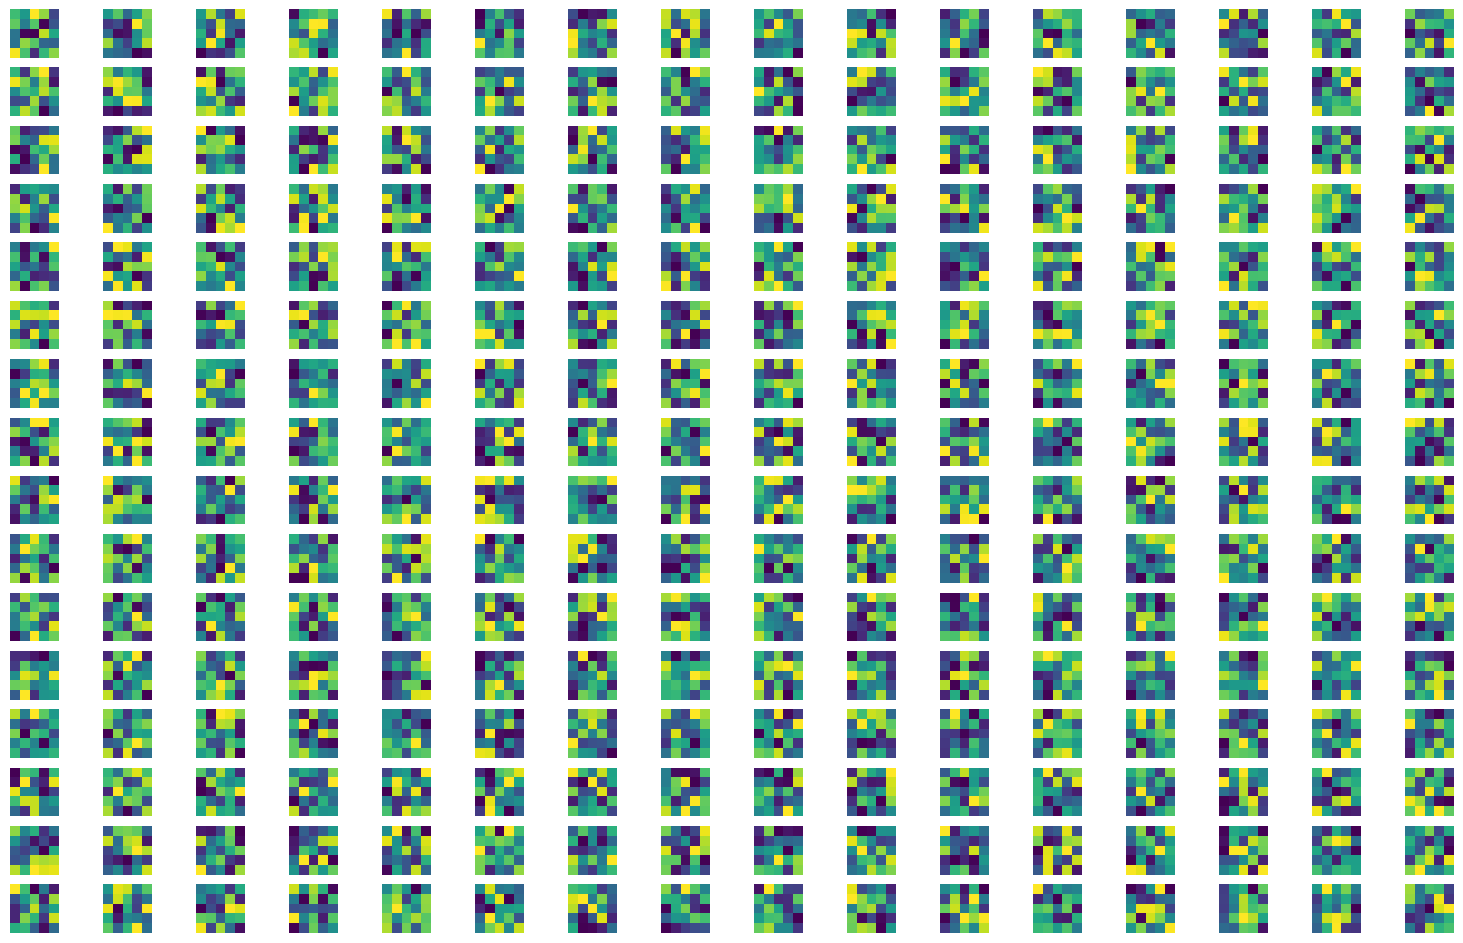

In [37]:
kernels = CNN_model.state_dict()['cnn2.weight']

num_rows = 16
num_cols = 16

# Calculate the total number of subplots needed
num_kernels = kernels.shape[0]
total_subplots = num_rows * num_cols

plt.figure(figsize=(19, 12))

# Loop through the kernels and plot them
for i in range(total_subplots):
    if i < num_kernels:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(kernels[i, 0].cpu().numpy(), cmap='viridis') 
        plt.axis('off')
    else:
        # Blank subplot for any unused positions
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')

plt.show()
